# Analyzing Beacon Data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import urllib

In [2]:
dir_path = 'ftp://data.munroelab.ca/pub/iceberg/beacon/'
dir_contents = urllib.request.urlopen(dir_path).read().splitlines()
filenames = [str(listing.split()[-1])[2:-1] for listing in dir_contents]
csv_filenames = [filename for filename in filenames if filename.startswith('0')
                and filename.endswith('csv')]
kml_filenames = [filename for filename in filenames if filename.startswith('0')
                and filename.endswith('kml')]
metadata_filename = filenames[-1]

In [3]:
beacon_metadata = pd.read_csv(dir_path + metadata_filename)

In [4]:
beacon_metadata

,BeaconID,IMEI,ArgosID,WMO,DataOwner,DataSharingRestrictions,Contact,BeaconType,Manufacturer,Transmitter,...,RelatedBeaconIDs,AdditionalDatasets,Project,Photos_Y_N,NumberPhotos,PhotoCredits,PhotoRestrictions,PhotoComments,PhotoNames,Comments
0,204980,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"906790, 2790480, 2792490","sail/keel mapping with laser and multibeam, CT...",Statoil/ArcticNet Research Cruise 2015,Y,7,"Derek Mueller, Anna Crawford",4,NaN,"204980_2015_approaching the saddle berg 1.JPG,...",Beacon deployed during ArcticNet/Statoil/WIRL ...
1,505190,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"907780, 2791420","photogrammetry, laser scanning",Statoil/ArcticNet Research Cruise 2015,Y,10,"Derek Mueller, Anna Crawford",4,NaN,"505190_2015_Approaching tabular berg.JPG, 5051...",Beacon deployed during ArcticNet/Statoil/WIRL ...
2,906790,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"204980, 2790480, 2792490","sail/keel mapping with laser and multibeam, CT...",Statoil/ArcticNet Research Cruise 2015,Y,See 204980,See 204980,4,NaN,see 204980,Beacon deployed during ArcticNet/Statoil/WIRL ...
3,907780,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"505190, 2791420","photogrammetry, laser scanning",Statoil/ArcticNet Research Cruise 2015,Y,See 505190,See 505190,4,NaN,see 505190,Beacon deployed during ArcticNet/Statoil/WIRL ...


In [5]:
def get_df(data_dir_path, data_fname):
    
    df = pd.read_csv(data_dir_path + data_fname)
    df.loc[:, 'DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])
    
    return df

In [13]:
df = get_df(dir_path, csv_filenames[1])

In [7]:
df.head()

,BeaconID,BeaconType,DataDate_UTC,TransmissionDate_UTC,Latitude,Longitude,VBatt,AT,ST,BP,Heading,Speed,LocAccuracy,MessageIndex,Satellites,GPSdelay,SNR,TTFF
0,204980,Solara,2015-04-24 15:16:06,NaN,51.45991,-51.55144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,204980,Solara,2015-04-24 15:16:40,NaN,51.45991,-51.55163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,204980,Solara,2015-04-24 15:17:14,NaN,51.45993,-51.55161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,204980,Solara,2015-04-24 15:17:48,NaN,51.45980,-51.55176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,204980,Solara,2015-04-24 15:18:14,NaN,51.46008,-51.55156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def get_day_idxs(dft, day_inc = 5):

    day_idxs = []
    day_js = []
    day_j = 0
    
    for i in range(len(df)):
        day = (dft[i] - dft[0]).days
        if day == day_j:
            day_idxs.append(i)
            day_js.append(day_j)
            day_j += day_inc
    
    return day_idxs, day_js

In [9]:
def plot_drift_track(df, data_fname):
    
    fig = plt.figure()

    x, y = df['Longitude'], df['Latitude']
    
    plt.scatter(x, y, s=2)
    
    t = df['DataDate_UTC']
    day_idxs, day_js = get_day_idxs(t)
    
    for i, day_idx in enumerate(day_idxs):
    
        plt.text(x[day_idx], y[day_idx], str(day_js[i]), fontsize=16, )
    
    plt.title(f'Drift Track from {data_fname}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    return fig

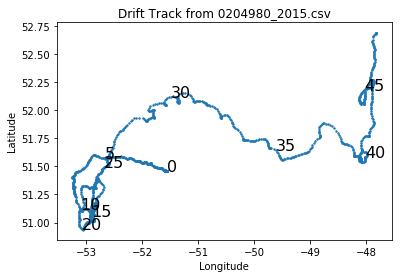

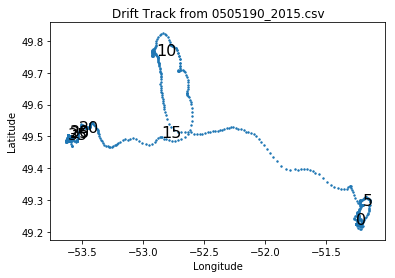

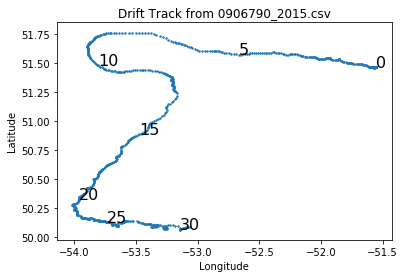

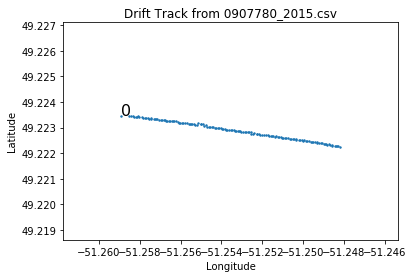

In [10]:
try:
    os.makedirs('plots')
except:
    pass

with PdfPages('plots/beacon_tracks.pdf') as pdf:
    for filename in csv_filenames:
        df = get_df(dir_path, filename)
        fig = plot_drift_track(df, filename)
        plt.show()
        plt.close()
        pdf.savefig(fig)

# Animation

In [11]:
from matplotlib import animation
from IPython.display import HTML

In [15]:
df0 = get_df(dir_path, csv_filenames[0])
df1 = get_df(dir_path, csv_filenames[1])
df2 = get_df(dir_path, csv_filenames[2])
df3 = get_df(dir_path, csv_filenames[3])

In [114]:
df = pd.concat([df0, df1, df2, df3], ignore_index=False)

In [115]:
df['old_index'] = pd.Series(df.index.values)
sorted_df = df.sort_values(by='DataDate_UTC').reset_index(drop=True)

In [55]:
sorted_df.BeaconID.unique()

array([ 50519,  90778, 204980,  90679])

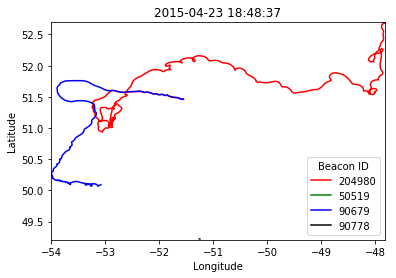

In [110]:
x0_list = df0.Longitude.values; y0_list = df0.Latitude.values; id0 = 204980
x1_list = df1.Longitude.values; y1_list = df1.Latitude.values; id1 = 50519
x2_list = df2.Longitude.values; y2_list = df2.Latitude.values; id2 = 90679
x3_list = df3.Longitude.values; y3_list = df3.Latitude.values; id3 = 90778

t_list = sorted_df.DataDate_UTC.values
x_list = sorted_df.Longitude.values
y_list = sorted_df.Latitude.values
id_list = sorted_df.BeaconID.values

fig, ax = plt.subplots()
ax.axis([min(x_list), max(x_list), min(y_list), max(y_list)])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('')

l0, = ax.plot([],[], color='red', label=str(id0))
l1, = ax.plot([],[], color='green', label=str(id1))
l2, = ax.plot([],[], color='blue', label=str(id2))
l3, = ax.plot([],[], color='black', label=str(id3))

ax.legend(loc='lower right', title='Beacon ID')

def animate(i):
    j = sorted_df.old_index[i]
    if id_list[i] == id0:
        l0.set_data(x0_list[:j], y0_list[:j])
    elif id_list[i] == id1:
        l1.set_data(x1_list[:j], y1_list[:j])
    elif id_list[i] == id2:
        l2.set_data(x2_list[:j], y2_list[:j])
    elif id_list[i] == id3:
        l3.set_data(x3_list[:j], y3_list[:j])
    else:
        pass
    ax.set_title(pd.Timestamp(t_list[i]))

anim = animation.FuncAnimation(fig, animate, frames=len(t_list), interval=20)#len(t_list))

HTML(anim.to_html5_video())